In [16]:
'''
Standard QPE suffers from a large amount of qubits needed in order to approximate the phase
up to a certain precision

Iterative QPE (IPE) works around the problem using just 1 qubit (plus the qubits needed to implement the eigenstate) 
and a classical register the size of which determines the level of accuracy 

The algorithms take advantages of the reset instruction to reiterate the procedure on the same qubit after 
storing the kth bit of the phase in the classical register
'''

'\nStandard QPE suffers from a large amount of qubits needed in order to approximate the phase\nup to a certain precision\n\nIterative QPE (IPE) works around the problem using just 1 qubit (plus the qubits needed to implement the eigenstate) \nand a classical register the size of which determines the level of accuracy \n\nThe algorithms take advantages of the reset instruction to reiterate the procedure on the same qubit after \nstoring the kth bit of the phase in the classical register\n'

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
sim = Aer.get_backend('qasm_simulator')

In [2]:
#aux functions for IPE algorithm
def x_measure(qc,qb,cb):
    qc.h(qb)
    qc.measure(qb,cb)
    qc.barrier()
    return qc

def reset_qc(qc):
    qc.reset(0)
    qc.h(0)
    qc.barrier()
    return qc


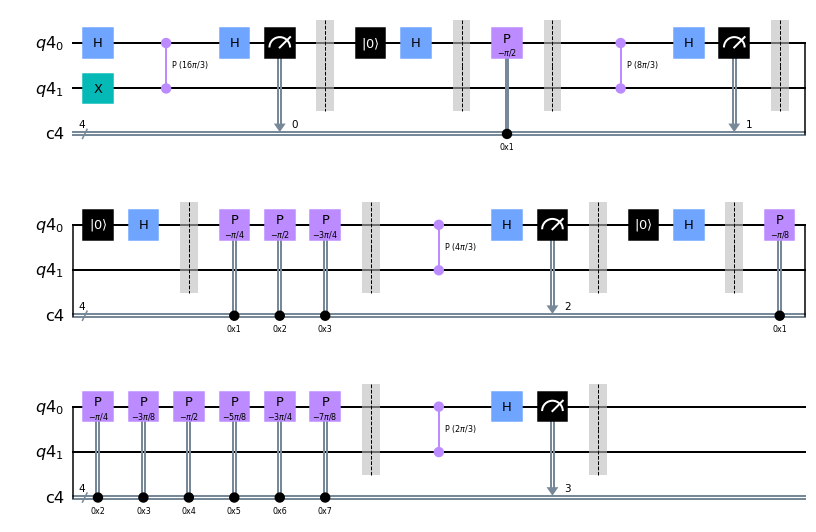

In [8]:
cb = 4
qr = QuantumRegister(2)
cr = ClassicalRegister(cb)

IPE = QuantumCircuit(qr,cr)

theta = 1/3

IPE.x(1)
IPE.h(0)

IPE.cp(2*np.pi*theta*2**(cb-1),0,1)
IPE = x_measure(IPE,0,0)


'''
The nested for loop with index n applies the correction to the phase of the 0th qbit
in order to make the algorithm work.

It checks the classical register with a classical if instruction and applies the right phase on the base
of which bit of the binary expansion of the phase is 1

In the kth step one has to applie a corrective phase -2*pi*0.0phi_(m-k+2)...phi_(m) 
with the phase expressed in m bits phi=0.phi_1...phi_m 

Expanding in binary the corrective phase is -2*pi*{phi_(m-k+2)/4 + ... + phi_m/2**m}

From this we see that in the kth step one has to apply 2**(k-1)-1 classical conditionals 
and the phases to be applied are -n*pi/2**(k-1) for n in {1,2,...,2**(k-1)-1}
'''
for k in range(2,cb+1):
    
    IPE = reset_qc(IPE)
    for n in range(1,2**(k-1)):
        IPE.p(-n*np.pi/2**(k-1),0).c_if(cr,n)
    IPE.barrier()
    IPE.cp(2*np.pi*theta*2**(cb-k),0,1)
    IPE = x_measure(IPE,0,k-1)
    
IPE.draw('mpl',fold=16)

In [4]:
#functions for qpe circuit

#cp(theta,c,t) are controlled rotation of angle theta controlled by 'c' on target 't'
#this function implement all the rotations the qft requires
def qft_rot(qc,n):
    if n==0:
        return qc
    n -= 1
    qc.h(n)
    for q in range(n):
        qc.cp(np.pi/(2**(n-q)),q,n)
    #applies H and rotation iteratively to every q bit from the most significant to the least sig.
    qft_rot(qc,n)

def swap_register(qc,n):
    for q in range(n//2):
        qc.swap(q,n-1-q)
    return qc

def qft(qc,n):
    qft_rot(qc,n)
    qc.barrier()
    swap_register(qc,n)
    return qc
    
#inverse qft
#append an inverse qft circuit to the first n qbits of an existing one
def inv_qft(qc,n):
    dum_circ = qft(QuantumCircuit(n),n)
    dum_circ = dum_circ.inverse()#invert i.e takes the adjoint
    #now append the inverse qft circuit (qft_circ) to qc
    dum_circ.name="QFT†"
    qc.append(dum_circ,qc.qubits[:n])
    return qc

#implementation of the operator
'''
qpe gives the theta in U|u>=exp(i2pitheta)|u>, 
here the funtion applies |u> -> exp(iangle)|u> via .cp() funcion,
so in order to find theta one has to give the function 2pi*angle as an argument
'''

def apply_U(qc,angle,t,qtot):

    circ_dum = QuantumCircuit(qtot)
    repetitions = 1
    for q in range(t):
        for k in range(repetitions):
            circ_dum.cp(angle,q,qtot-1)#operator
        repetitions *= 2
    circ_dum.name="U"
    qc.append(circ_dum,qc.qubits[:qtot])    
    return qc

def qpe(qc,t,l,theta):
    
    qtot=t+l
    #qc = QuantumCircuit(qtot,t)
    
    for q in range(t):
        qc.h(q)
    
    #implementation of the eigenstate |1>
    qc.x(qtot-1)
    
    qc.barrier()
    
    angle = 2*np.pi*theta #qpe works with 2pi*theta
    qc = apply_U(qc,angle,t,qtot)
    qc.barrier()
    qc = inv_qft(qc,t)
    qc.barrier()
    
    return qc

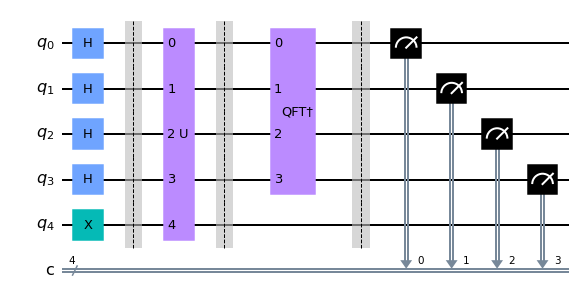

In [5]:
t = 4
l = 1
qtot = t+l
theta = 1/3

QPE = QuantumCircuit(qtot,t)
QPE = qpe(QPE,t,l,theta)

    
for q in range(t):
    QPE.measure(q,q)
QPE.draw('mpl')

In [ ]:
'''
From here we have to choose if we want to run the circuit on a simulator with a noise model or 
on a real device, note that currently (feb 2022), no real ibm device supports the classical
conditionals that the ipe algorithm requires
'''

In [6]:
'''
Transpiling for the noisy simulator
'''
from qiskit.test.mock import FakeAthens
import qiskit.tools.jupyter

backend_fake = FakeAthens()
backend_fake

initial_layout=[0,1]

IPE_trans = transpile(IPE, backend_fake, initial_layout=initial_layout, optimization_level=3)

print("Depth of IPE transpiled circuit: ",IPE_trans.depth())

#num is the number of transpiled circuit from which we will pick the one with the least depth
num = 300
QPE_trans = transpile([QPE]*num, backend_fake, optimization_level=3)
QPE_trans_depth = np.array([QPE_trans[idx].depth() for idx in range(num)])
print("Min depth of QPE transpiled circuit: ",min(QPE_trans_depth))
print("Max depth of QPE transpiled circuit : ", max(QPE_trans_depth))
best_arg = np.argmin(QPE_trans_depth)
QPE_trans_best = QPE_trans[best_arg]

Depth of IPE transpiled circuit:  53
Min depth of QPE transpiled circuit:  81
Max depth of QPE transpiled circuit :  106


In [7]:
'''
here we use a simulator with a noise model imported from a real device
'''
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend_fake)

shots = 20000

ipe_noisy_res = execute(IPE_trans, sim, noise_model=noise_model,shots=shots).result()
qpe_noisy_res = execute(QPE_trans_best, sim, noise_model=noise_model,shots=shots).result()

qpe_noisy_counts = qpe_noisy_res.get_counts() 
ipe_noisy_counts = ipe_noisy_res.get_counts()

In [ ]:
##############################################################

In [27]:
'''
here we use a real device
'''
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                    and not x.configuration().simulator
                                    and x.status().operational==True)

backend_real = least_busy(small_devices)

print(backend_real.name())
#backend

ibmq_bogota


In [28]:
IPE_trans_real = transpile(IPE, backend_real, optimization_level=3)

print("Depth of IPE transpiled circuit in real device: ",IPE_trans_real.depth())

#num is the number of transpiled circuit from which we will pick the one with the least depth
num = 300
QPE_trans_real = transpile([QPE]*num, backend_real, optimization_level=3)
QPE_trans_real_depth = np.array([QPE_trans_real[idx].depth() for idx in range(num)])
print("Min depth of QPE transpiled circuit: ",min(QPE_trans_real_depth))
print("Max depth of QPE transpiled circuit : ", max(QPE_trans_real_depth))
best_arg = np.argmin(QPE_trans_real_depth)
QPE_trans_real_best = QPE_trans_real[best_arg]

Depth of IPE transpiled circuit in real device:  53
Min depth of QPE transpiled circuit:  81
Max depth of QPE transpiled circuit :  109


In [32]:
shots = 20000

ipe_real_job = backend.run(IPE_trans_real,shots=shots)
qpe_real_job = backend.run(QPE_trans_real_best,shots=shots)

print(ipe_real_job.job_id())
print(qpe_real_job.job_id())
job_monitor(ipe_real_job)
job_monitor(qpe_real_job)

61fa6abf72edae1949e94a17
61fa6ac21d5cb6481da7ae59
Job Status: job incurred error     
Job Status: job has successfully run


In [ ]:
shots = 20000

ipe_real_res = ipe_real_job.get_result()
qpe_real_res = qpe_real_job.get_result()

ipe_real_counts = ipe_real_res.get_counts()
qpe_real_counts = qpe_real_res.get_counts() 

In [ ]:
##############################################################

In [8]:
'''
here we use a simulator
'''
IPE_trans_exact = transpile(IPE, sim)
QPE_trans_exact = transpile(QPE,sim)

ipe_exact_res = execute(IPE_trans_exact, sim,shots=shots).result()
qpe_exact_res = execute(QPE_trans_exact, sim,shots=shots).result()

qpe_exact_counts = qpe_exact_res.get_counts() 
ipe_exact_counts = ipe_exact_res.get_counts()

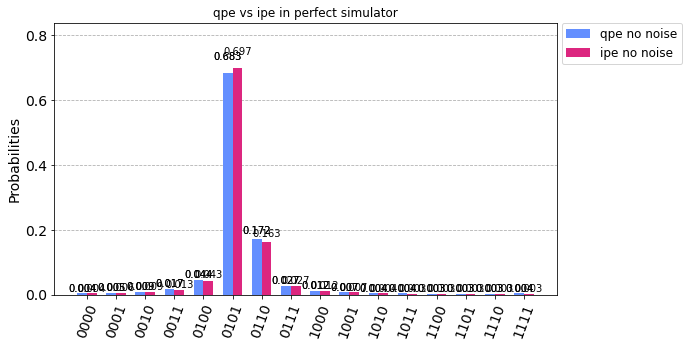

In [11]:
plot_histogram([qpe_exact_counts,ipe_exact_counts],legend=['qpe no noise','ipe no noise'],
               figsize=(9,5),title='qpe vs ipe in perfect simulator')#.savefig(


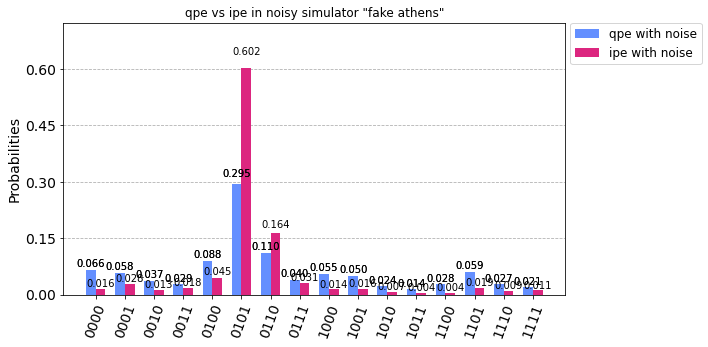

In [14]:
plot_histogram([qpe_noisy_counts,ipe_noisy_counts], legend=['qpe with noise', 'ipe with noise'],
               figsize=(9,5),title='qpe vs ipe in noisy simulator "fake athens"')#.savefig(

